In [81]:
import numpy as np
import matplotlib.pyplot as plt

clean = np.load("/content/data/EEG_all_epochs.npy")
EMG = np.load("/content/data/EMG_all_epochs.npy")
EOG = np.load("/content/data/EOG_all_epochs.npy")

print(clean.shape)
print(EMG.shape)
print(EOG.shape)


(4514, 512)
(5598, 512)
(3400, 512)


In [82]:
def combine(signal, noise, db):
  sigRMS = np.sqrt(np.mean(signal**2))
  noiseRMS = np.sqrt(np.mean(noise**2))
  ratio = sigRMS/noiseRMS
  lamda = np.exp(-db/10)*ratio
  return signal + lamda*noise
def SNR_calc(signal, noise):
  sigRMS = np.sqrt(np.mean(signal**2))
  noiseRMS = np.sqrt(np.mean(noise**2))
  ratio = sigRMS/noiseRMS
  SNR = 10*np.log(ratio)
  return SNR

print(SNR_calc(clean[0], EOG[0]))

15.451530267548497


In [83]:
num_samples = 3400
random_indices = np.random.choice(3400, size=num_samples, replace=False)

selected_clean_eog_epochs = clean[random_indices]
selected_eog_epochs = EOG[random_indices]

In [84]:
num_samples = selected_clean_eog_epochs.shape[0]
epoch_length = selected_clean_eog_epochs.shape[1]


combined_signals_eog = np.zeros((num_samples, epoch_length))
combined_signal_eog_snr = np.random.choice(list(range(-7,3)),num_samples) # SNR Db range: [-7,2]

for i in range(num_samples):
    clean_epoch = selected_clean_eog_epochs[i]
    eog_epoch = selected_eog_epochs[i]
    db = combined_signal_eog_snr[i]
    combined_signals_eog[i] = combine(clean_epoch, eog_epoch, db)

combined_signals_eog.shape

(3400, 512)

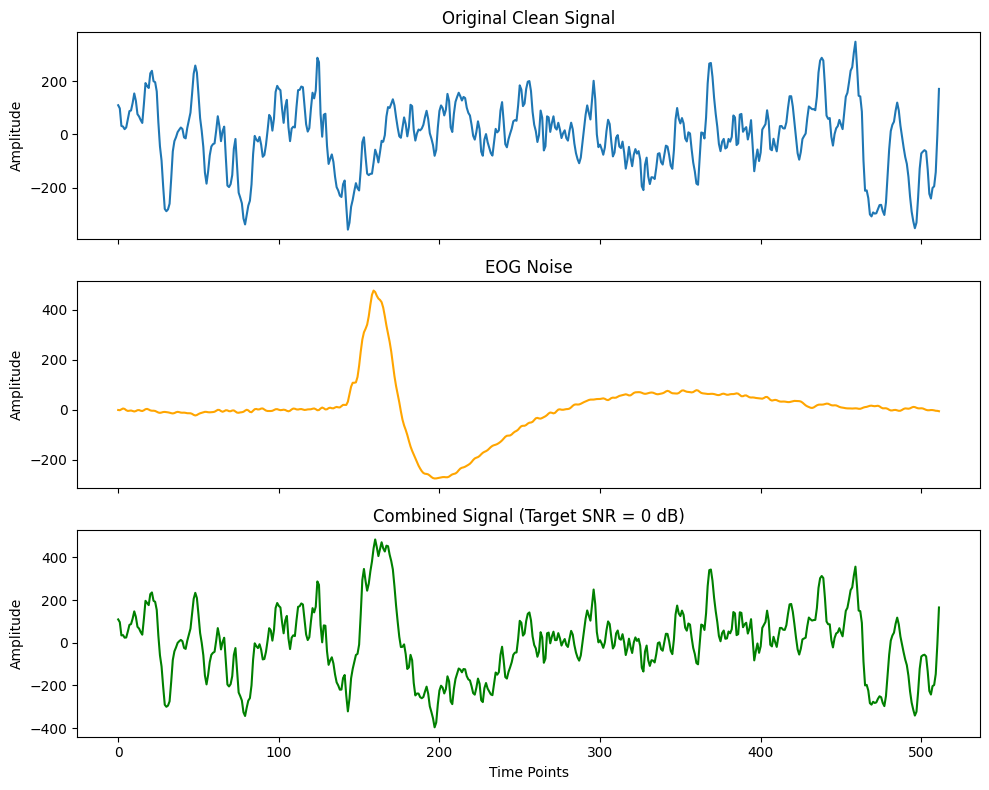

In [85]:
random_index = np.random.randint(0, num_samples)

clean_to_plot = selected_clean_eog_epochs[random_index]
eog_to_plot = selected_eog_epochs[random_index]
combined_to_plot = combined_signals_eog[random_index]
db = combined_signal_eog_snr[random_index]


fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(clean_to_plot)
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Original Clean Signal')

axes[1].plot(eog_to_plot, color='orange')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('EOG Noise')

axes[2].plot(combined_to_plot, color='green')
axes[2].set_ylabel('Amplitude')
axes[2].set_title(f'Combined Signal (Target SNR = {db} dB)')

axes[2].set_xlabel('Time Points')

plt.tight_layout()

plt.show()

In [86]:
num_samples = 4500
random_indices = np.random.choice(4514, size=num_samples, replace=False)

selected_clean_emg_epochs = clean[random_indices]
selected_emg_epochs = EMG[random_indices]

selected_clean_emg_epochs.shape

(4500, 512)

In [87]:
num_samples = selected_clean_emg_epochs.shape[0]
epoch_length = selected_clean_emg_epochs.shape[1]

combined_signals_emg = np.zeros((num_samples, epoch_length))
combined_signals_emg_snr = np.random.choice(list(range(-7,5)),num_samples) # SNR Db range: [-7;4]

for i in range(num_samples):
    clean_epoch = selected_clean_emg_epochs[i]
    eog_epoch = selected_emg_epochs[i]
    db = combined_signals_emg_snr[i]
    combined_signals_emg[i] = combine(clean_epoch, eog_epoch, db)

combined_signals_emg.shape

(4500, 512)

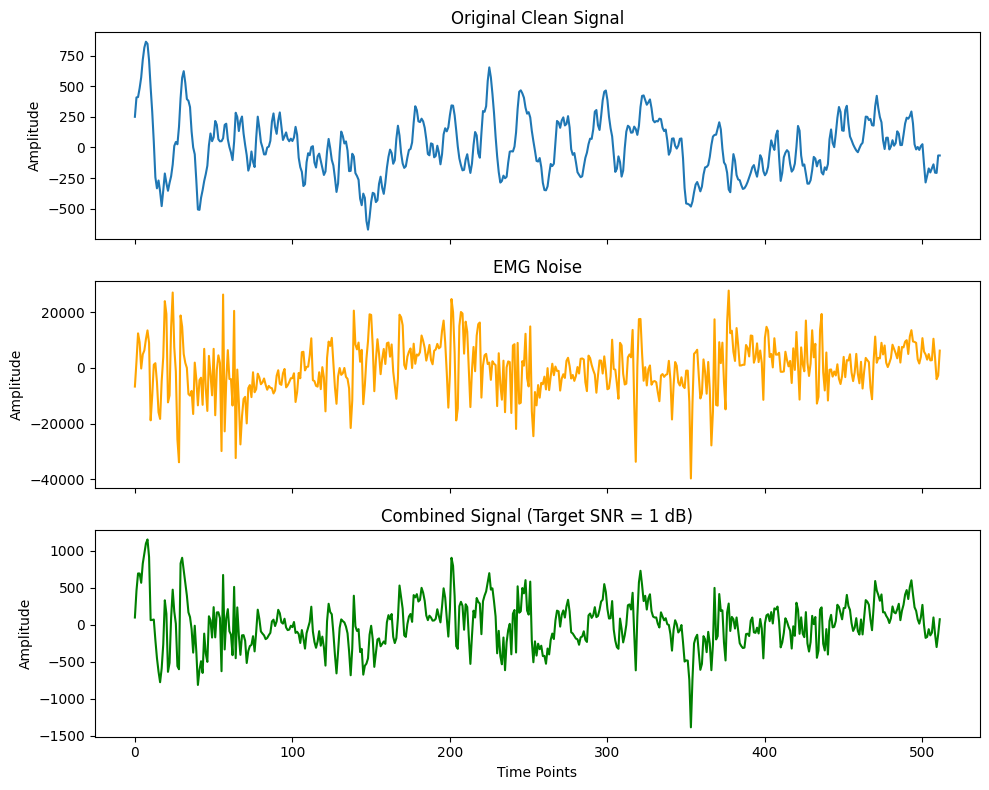

In [88]:
random_index = np.random.randint(0, num_samples)

clean_to_plot = selected_clean_emg_epochs[random_index]
eog_to_plot = selected_emg_epochs[random_index]
combined_to_plot = combined_signals_emg[random_index]
db = combined_signals_emg_snr[random_index]

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(clean_to_plot)
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Original Clean Signal')

axes[1].plot(eog_to_plot, color='orange')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('EMG Noise')

axes[2].plot(combined_to_plot, color='green')
axes[2].set_ylabel('Amplitude')
axes[2].set_title(f'Combined Signal (Target SNR = {db} dB)')

axes[2].set_xlabel('Time Points')

plt.tight_layout()

plt.show()

In [89]:
from torch import nn

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten() # Flattens out the image into a vector
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
    )

  def forward(self, x):
    x = self.flatten(x)
    return self.linear_relu_stack(x)

print(NeuralNetwork())

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
  )
)


In [90]:
train_test_split = 0.7

num_samples_eog = combined_signals_eog.shape[0]

train_data_X = combined_signals_eog[:int(train_test_split*num_samples_eog)]
test_data_X = combined_signals_eog[int(train_test_split*num_samples_eog):]

train_data_Y = selected_clean_eog_epochs[:int(train_test_split*num_samples_eog)]
test_data_Y = selected_clean_eog_epochs[int(train_test_split*num_samples_eog):]

print(f"Shape of train_data_X: {train_data_X.shape}")
print(f"Shape of test_data_X: {test_data_X.shape}")
print(f"Shape of train_data_Y: {train_data_Y.shape}")
print(f"Shape of test_data_Y: {test_data_Y.shape}")

Shape of train_data_X: (2380, 512)
Shape of test_data_X: (1020, 512)
Shape of train_data_Y: (2380, 512)
Shape of test_data_Y: (1020, 512)


In [91]:
from torch.utils.data import DataLoader, TensorDataset
import torch

batch_size = 40

# Convert numpy arrays to torch tensors
train_data_X_tensor = torch.tensor(train_data_X, dtype=torch.float32)
train_data_Y_tensor = torch.tensor(train_data_Y, dtype=torch.float32)
test_data_X_tensor = torch.tensor(test_data_X, dtype=torch.float32)
test_data_Y_tensor = torch.tensor(test_data_Y, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_data_X_tensor, train_data_Y_tensor)
test_dataset = TensorDataset(test_data_X_tensor, test_data_Y_tensor)

train_dataloader = DataLoader(
  train_dataset,
  batch_size=batch_size,
  shuffle=True # Whether to shuffle the data every loop, useful for SGD
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of testing batches: {len(test_dataloader)}")

# Example of how data is structured in a batch
for X_batch, Y_batch in train_dataloader:
    print(f"Shape of X batch: {X_batch.shape}")
    print(f"Shape of Y batch: {Y_batch.shape}")
    break

Number of training batches: 60
Number of testing batches: 26
Shape of X batch: torch.Size([40, 512])
Shape of Y batch: torch.Size([40, 512])


In [92]:
from tqdm import tqdm # This is a library that implements loading bars
import sys

def train_epoch(dataloader, model, loss_fn, optimizer):
  model.train() # Set model to training mode

  total_loss = 0
  total_batches = 0

  with tqdm(dataloader, unit="batch", file=sys.stdout) as ep_tqdm:
    ep_tqdm.set_description("Train")
    for X, y in ep_tqdm:
      X, y = X.to(device), y.to(device)

      # Forward pass
      pred = model(X)
      loss = loss_fn(pred, y)

      # Backward pass
      loss.backward()
      optimizer.step()

      # Reset the computed gradients back to zero
      optimizer.zero_grad()

      # Output stats
      total_loss += loss
      total_batches += 1
      ep_tqdm.set_postfix(average_batch_loss=(total_loss/total_batches).item())

def eval_epoch(dataloader, model, loss_fn):
  model.eval() # Set model to inference mode

  total_loss = 0
  total_batches = 0
  # Removed total_samples and total_correct as they are for classification

  with torch.no_grad(): # Do not compute gradients
    with tqdm(dataloader, unit="batch", file=sys.stdout) as ep_tqdm:
      ep_tqdm.set_description("Val")
      for X, y in ep_tqdm:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        total_loss += loss_fn(pred, y)
        total_batches += 1

        ep_tqdm.set_postfix(average_batch_loss=(total_loss/total_batches).item()) # Display average loss

def denoise_loss_mse(denoise, clean):
  loss = (denoise - clean)**2
  return torch.mean(loss)

def denoise_loss_rmse(denoise, clean):
  mse = denoise_loss_mse(denoise, clean)
  return torch.sqrt(mse)

def denoise_loss_rrmset(denoise, clean):
  rmse1 = denoise_loss_rmse(denoise, clean)
  rmse2 = denoise_loss_rmse(clean, torch.zeros_like(clean))
  epsilon = 1e-6
  return rmse1 / (rmse2 + epsilon)


In [93]:
#| output-location: slide
# Use GPU if available
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = NeuralNetwork().to(device)

# Hyperparameters
learning_rate = 0.001
epochs = 15

loss_fn = denoise_loss_rrmset
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Organize the training loop
for t in range(epochs):
  print(f"Epoch {t+1}\n")
  train_epoch(train_dataloader, model, loss_fn, optimizer)
  eval_epoch(test_dataloader, model, loss_fn)
  print("-------------------------------")

print("Done!")

Using cuda device
Epoch 1

Val: 100%|██████████| 26/26 [00:00<00:00, 411.38batch/s, average_batch_loss=0.752]
-------------------------------
Epoch 2

Val: 100%|██████████| 26/26 [00:00<00:00, 412.52batch/s, average_batch_loss=0.66]
-------------------------------
Epoch 3

Val: 100%|██████████| 26/26 [00:00<00:00, 389.07batch/s, average_batch_loss=0.603]
-------------------------------
Epoch 4

Val: 100%|██████████| 26/26 [00:00<00:00, 354.94batch/s, average_batch_loss=0.568]
-------------------------------
Epoch 5

Val: 100%|██████████| 26/26 [00:00<00:00, 388.47batch/s, average_batch_loss=0.547]
-------------------------------
Epoch 6

Val: 100%|██████████| 26/26 [00:00<00:00, 423.64batch/s, average_batch_loss=0.531]
-------------------------------
Epoch 7

Val: 100%|██████████| 26/26 [00:00<00:00, 378.24batch/s, average_batch_loss=0.513]
-------------------------------
Epoch 8

Val: 100%|██████████| 26/26 [00:00<00:00, 414.98batch/s, average_batch_loss=0.502]
-----------------------

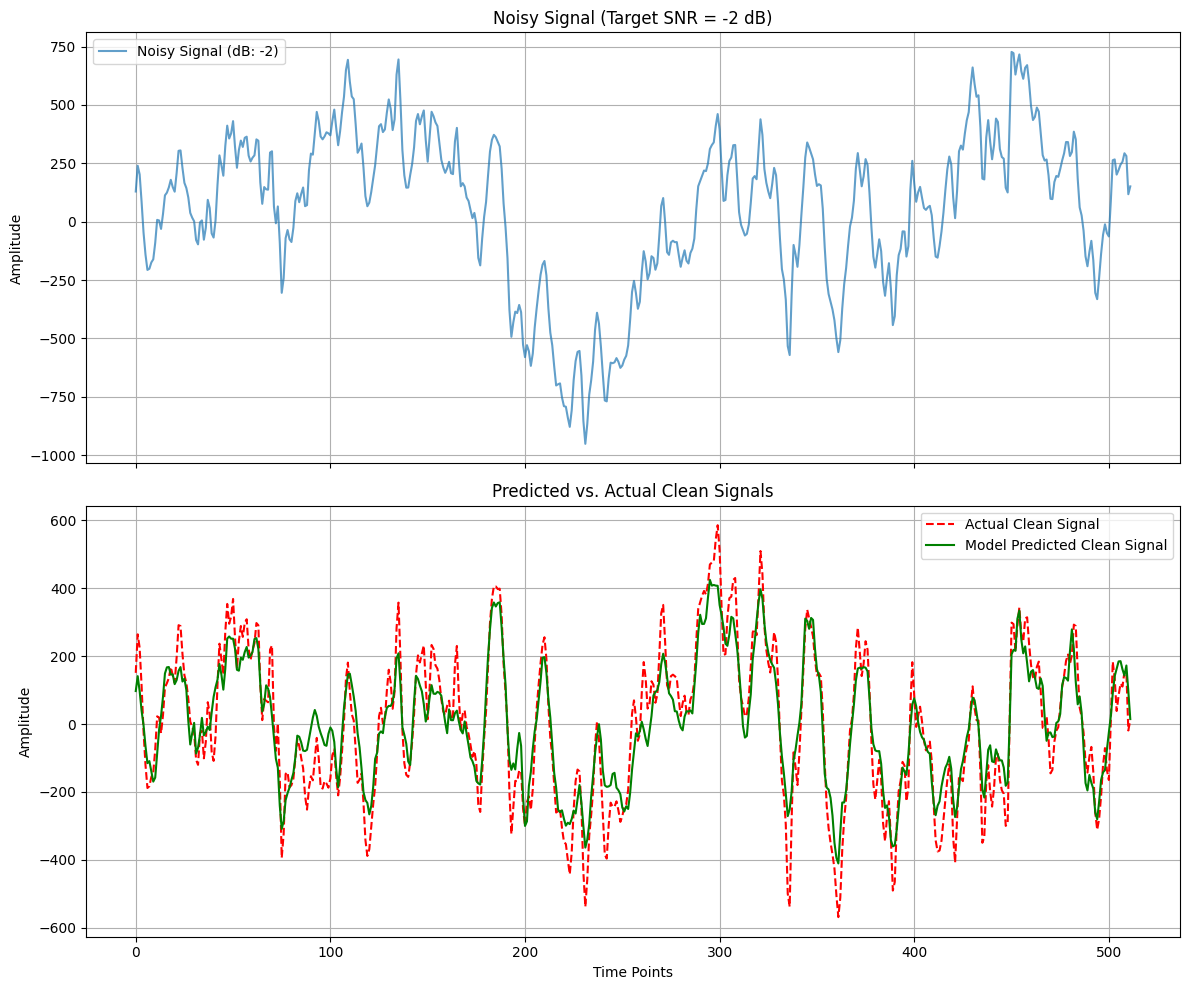

In [80]:
def model_plot():
    model.eval() # Set the model to evaluation mode

    random_idx = torch.randint(0, len(test_dataset), (1,)).item()

    noisy_input_tensor, actual_clean_tensor = test_dataset[random_idx]

    # Move the input to the device (CPU/GPU) and get model prediction
    with torch.no_grad():
        # Add a batch dimension to the noisy_input_tensor before passing it to the model
        predicted_clean_tensor = model(noisy_input_tensor.unsqueeze(0).to(device)).cpu()

    noisy_input = noisy_input_tensor.numpy()
    predicted_clean = predicted_clean_tensor.squeeze(0).numpy()
    actual_clean = actual_clean_tensor.numpy()

    offset = int(train_test_split * num_samples_eog)
    original_index_in_combined = offset + random_idx
    db_value = combined_signal_eog_snr[original_index_in_combined]

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    axes[0].plot(noisy_input, label=f'Noisy Signal (dB: {db_value})', alpha=0.7)
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title(f'Noisy Signal (Target SNR = {db_value} dB)')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(actual_clean, label='Actual Clean Signal', color='red', linestyle='--')
    axes[1].plot(predicted_clean, label='Model Predicted Clean Signal', color='green', linestyle='-')
    axes[1].set_xlabel('Time Points')
    axes[1].set_ylabel('Amplitude')
    axes[1].set_title('Predicted vs. Actual Clean Signals')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

model_plot()

In [94]:
#| output-location: slide

from torch import nn

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.convolution = nn.Sequential(
      # Replicated TensorFlow Conv1D block
      nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm1d(num_features=64),
      nn.ReLU(),
      nn.Dropout(0.3),

      nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm1d(num_features=64),
      nn.ReLU(),
      nn.Dropout(0.3),

      nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm1d(num_features=64),
      nn.ReLU(),
      nn.Dropout(0.3),

      nn.MaxPool1d(kernel_size=2),
      nn.BatchNorm1d(num_features=64),
      nn.Conv1d(in_channels=64, out_channels=24, kernel_size=3, padding=1),
      nn.MaxPool1d(kernel_size=2)
    )
    self.flatten = nn.Flatten()

    self.linear_relu_stack = nn.Sequential(
      nn.Linear(3072, 1028), # Adjusted input features
      nn.ReLU(),
      nn.Linear(1028, 1028),
      nn.ReLU(),
      nn.Linear(1028, 512),
    )

  def forward(self, x):
    # Add a channel dimension for Conv1d: [batch, 512] -> [batch, 1, 512]
    x = x.unsqueeze(1)
    x = self.convolution(x)
    x = self.flatten(x)
    return self.linear_relu_stack(x)

print(CNN())

CNN(
  (convolution): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv1d(64, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [95]:
#| output-location: slide

# Use GPU if available
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = CNN().to(device) # This tells pytorch which device to use when training and inferencing

# Hyperparameters
learning_rate = 0.001
epochs = 15

loss_fn = denoise_loss_rrmset
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Initialize the optimizer

# Organize the training loop
for t in range(epochs):
  print(f"Epoch {t+1}\n")
  train_epoch(train_dataloader, model, loss_fn, optimizer)
  eval_epoch(test_dataloader, model, loss_fn)
  print("-------------------------------")

print("Done!")

Using cuda device
Epoch 1

Val: 100%|██████████| 26/26 [00:00<00:00, 320.51batch/s, average_batch_loss=0.917]
-------------------------------
Epoch 2

Val: 100%|██████████| 26/26 [00:00<00:00, 286.33batch/s, average_batch_loss=0.775]
-------------------------------
Epoch 3

Val: 100%|██████████| 26/26 [00:00<00:00, 320.49batch/s, average_batch_loss=0.68]
-------------------------------
Epoch 4

Val: 100%|██████████| 26/26 [00:00<00:00, 312.72batch/s, average_batch_loss=0.603]
-------------------------------
Epoch 5

Val: 100%|██████████| 26/26 [00:00<00:00, 290.21batch/s, average_batch_loss=0.561]
-------------------------------
Epoch 6

Val: 100%|██████████| 26/26 [00:00<00:00, 298.10batch/s, average_batch_loss=0.524]
-------------------------------
Epoch 7

Val: 100%|██████████| 26/26 [00:00<00:00, 298.76batch/s, average_batch_loss=0.508]
-------------------------------
Epoch 8

Val: 100%|██████████| 26/26 [00:00<00:00, 283.85batch/s, average_batch_loss=0.48]
------------------------

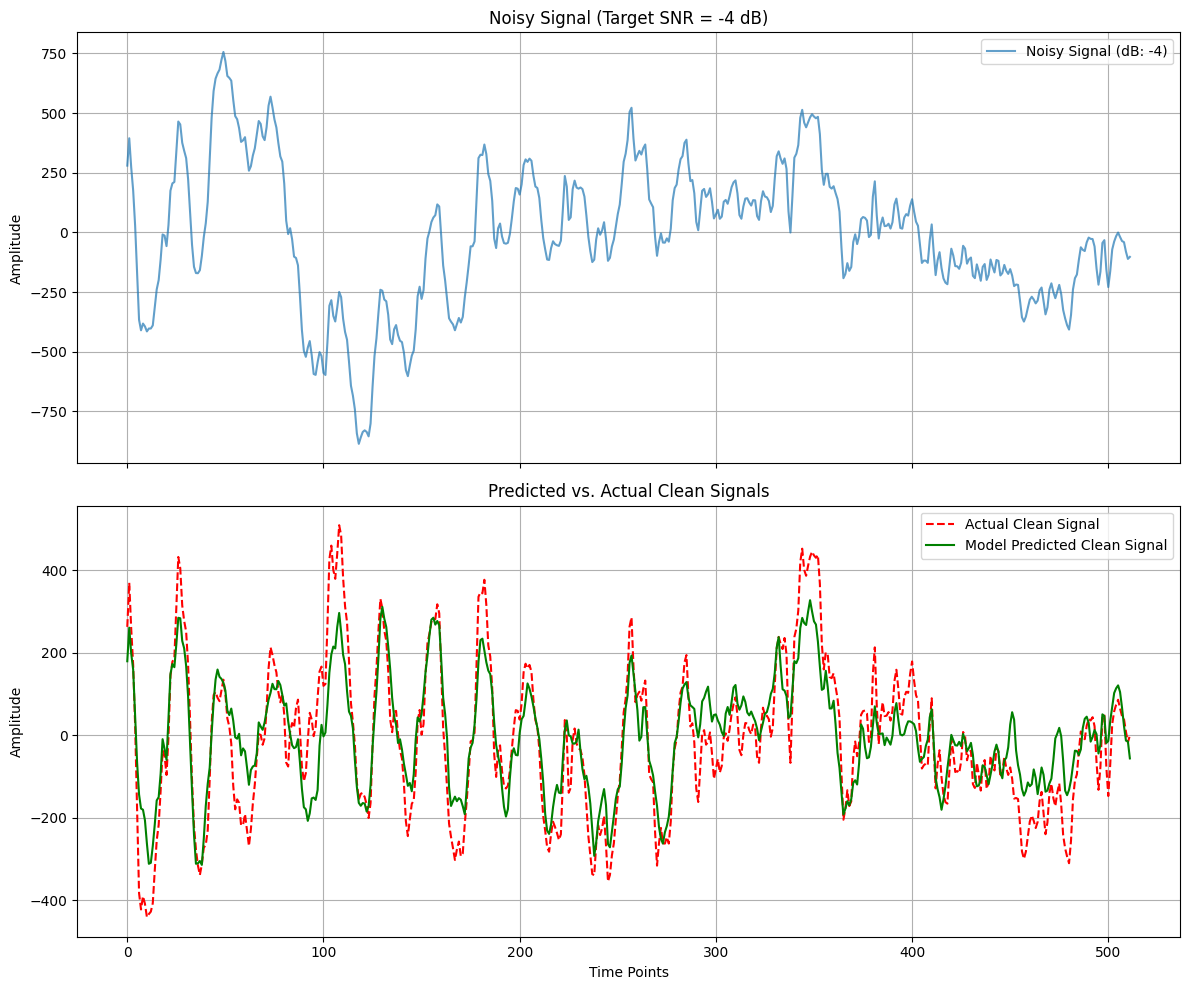

In [96]:
model_plot()